Name: Pantelis Zoumpoulidis 

StudentID: 2085764

Candidate Number: 10087

Email: pantelis.zoumpoulidis.2020@bristol.ac.uk

# Question 2

## Introduction

In this section, we are given a dataset from a bicycle hire company interested in the bicycle demand given several factors: the season, the day of the week, and the weather. Season, as expected, refers to the season of the year, day of the week to either the day is a workday or a weekend, and weather to a range of three conditions from sunny to stormy. Our goal is to build a decision tree from scratch without using pre-existing libraries to predict the demand.

In [1]:
# import libraries
import numpy as np
import pandas as pd

# import dataset
originalDataset = pd.read_csv("/Users/zoumpp/Documents/Data Science MSc/Teaching Block 2 (TB2)/Introduction to Artificial Inteligence/Assessment/Part 1/coursework2.csv")

# display first five rows
originalDataset.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,count
0,1,01/01/2011,1,0,1,0,6,0,2,14.11,18.18,0.81,0.16,331,654,985
1,2,02/01/2011,1,0,1,0,0,0,2,14.90,17.69,0.70,0.25,131,670,801
2,3,03/01/2011,1,0,1,0,1,1,1,8.05,9.47,0.44,0.25,120,1229,1349
3,4,04/01/2011,1,0,1,0,2,1,1,8.20,10.61,0.59,0.16,108,1454,1562
4,5,05/01/2011,1,0,1,0,3,1,1,9.31,11.46,0.44,0.19,82,1518,1600


## Methods

The matrix above is a preview of our dataset's first five rows, consisting of {{np.shape(originalDataset)[0]}} observations and {{np.shape(originalDataset)[1]}} features. We will use the columns "season", "workingday", weathersit", and "count" for our problem. The latter relates to the demand for bicycles. We plot a histogram to identify the distribution of the data.

In [2]:
# create a new dataset with the needed columns
dataset = originalDataset[["season", "workingday", "weathersit", "count"]]

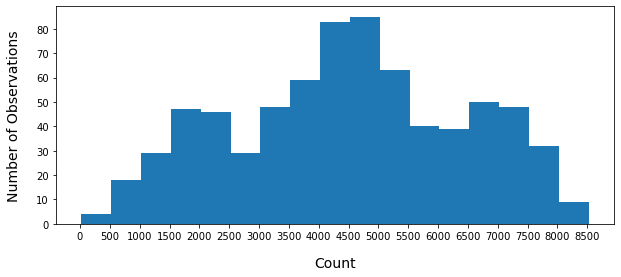

In [3]:
# import matplot
import matplotlib.pyplot as plt

# plot the histogram of counts
plt1, ax1 = plt.subplots(figsize = (10, 4))
ax1.hist(dataset["count"], bins = range(min(dataset["count"]), max(dataset["count"]), 500))
ax1.set_xlabel("Count", size = 14, labelpad = 15)
ax1.set_ylabel("Number of Observations", size = 14, labelpad = 15)
trash = ax1.set_xticks(range(0, max(dataset["count"]), 500))

We observe in the previous histogram that there are three areas that most of the data are distributed. The first is from 0 to 3000, the second from 3000 to 6000, and the last one from 6000 to the end. We will divide the data into three categories "low", "medium", and "high" in a new column called "usage". In order to split the values more accurately, we will use Gaussian Mixture Models Clustering.

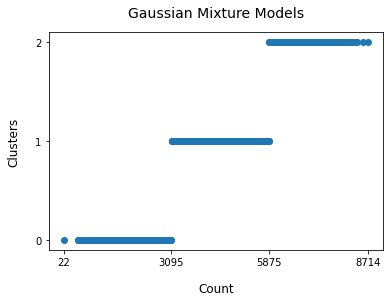

In [4]:
# import libraries
from sklearn.mixture import GaussianMixture as GMM

# reshape count column to fit it to the models
datasetCount = dataset["count"].to_numpy().reshape(-1, 1)

# instantiate GMM cluster with 3 components and a random state to ensure reproducibility
gmm = GMM(n_components = 3, random_state = 19)
# fit the data to the model
gmm.fit(datasetCount)
# predict the clusters
gmmPredictions = gmm.predict(datasetCount)
# create new data frame with the counts their labels from the algorithm
gmmDataFrame = pd.DataFrame(dataset["count"])
gmmDataFrame["label"] = pd.Series(gmmPredictions, index = gmmDataFrame.index)

# plot the results
plt2, ax2 = plt.subplots(figsize = (6, 4))

# ranges of clusters
clusterRange = [min(gmmDataFrame.loc[gmmDataFrame["label"] == 0]["count"]), max(gmmDataFrame.loc[gmmDataFrame["label"] == 0]["count"]), max(gmmDataFrame.loc[gmmDataFrame["label"] == 1]["count"]), max(gmmDataFrame.loc[gmmDataFrame["label"] == 2]["count"])]

ax2.scatter(gmmDataFrame["count"], gmmDataFrame["label"])
ax2.set_yticks(np.arange(0, 3, 1))
ax2.set_xticks(clusterRange)
ax2.set_title("Gaussian Mixture Models", size = 14, pad = 15)
ax2.set_ylabel("Clusters", size = 12, labelpad = 15)
trash = ax2.set_xlabel("Count", size = 12, labelpad = 15)

In [5]:
# define the conditions for the categories
def conditions(row, maxLow = max(gmmDataFrame.loc[gmmDataFrame["label"] == 0]["count"]), maxMedium = max(gmmDataFrame.loc[gmmDataFrame["label"] == 1]["count"])):
    if row["count"] <= maxLow: return "low"
    elif row["count"] > maxLow and row["count"] <= maxMedium: return "medium"
    elif row["count"] > maxMedium: return "high"

# turn off copy warning
pd.options.mode.chained_assignment = None
# add new column named usage with the categories of the values
dataset["usage"] = dataset.apply(conditions, axis = 1)
# display the first five rows
dataset.head(5)

,season,workingday,weathersit,count,usage
0,1,0,2,985,low
1,1,0,2,801,low
2,1,1,1,1349,low
3,1,1,1,1562,low
4,1,1,1,1600,low


We look at our updated dataset with the new "usage" column, and we proceed by deleting the not-needed column "count".

In [6]:
# delete not needed column count
dataset = dataset.drop(["count"], axis = 1)
# displau the first five rows
dataset.head(5)

,season,workingday,weathersit,usage
0,1,0,2,low
1,1,0,2,low
2,1,1,1,low
3,1,1,1,low
4,1,1,1,low


We are now ready to proceed with the first steps towards the creation of the decision tree. First of all, we need to write a function to calculate the entropy of a subset of the target values. Entropy helps us find the most meaningful feature to be the root of the tree or a subtree. Ideally, a good attribute would split the data into subsets whose labels are discrete from one another. Entropy is measured by:

$$H(x) = -\sum_{x}{p(x)log_{2}(p(x))}$$

where $p(x)$ is the probability mass function. The $x$ under the $\sum$ refers to the different classes of the target values we need to compute for every child of the tree or subtree. With that said, we continue with calculating the entropy of the subsets of the target values.

In [7]:
# import math
import math

# function to sort the labels from smallest to biggest for a number of cases
def sortLabels(labels):
    
    if False not in [type(value) == str for value in labels]:
        if len(labels) == 3 and False not in [value in map(str.lower, labels) for value in ["low", "medium", "high"]]:
            return [label for value in ["low", "medium", "high"] for label in labels if value in str.lower(label)]
        elif len(labels) == 2 and False not in [value in map(str.lower, labels) for value in ["low", "high"]]:
            return [label for value in ["low", "high"] for label in labels if value in str.lower(label)]
        elif len(labels) == 2 and False not in [value in map(str.lower, labels) for value in ["yes", "no"]]:
            return [label for value in ["yes", "no"] for label in labels if value in str.lower(label)]
        elif len(labels) == 2 and False not in [value in map(str.lower, labels) for value in ["on", "off"]]:
            return [label for value in ["on", "off"] for label in labels if value in str.lower(label)]
        else:
            return np.sort(labels)
    else:
        return np.sort(labels)

# function to return the labels of the target value    
def getLabels(dataset, target):
    
    return sortLabels(pd.unique(dataset[target]))    

# function to return the attributes of the dataset
def getAttributes(dataset, target):
    
    return sortLabels((dataset.drop([target], axis = 1).columns))
    
# function to calculate the entropy of a subset
def calculateEntropyOfSubset(dataset, target, value):
    observations = np.shape(dataset)[0]
    targetObservations = np.shape(dataset.loc[dataset[target] == value])[0]
    pTarget = targetObservations / observations
    
    if pTarget == 0:
        return 0
    else:
        return round( - (pTarget * math.log2(pTarget)), 4)

# function to calculate the entropies of all subsets
def calculateEntropyOfSubsets(dataset, target, labels):
    entropies = []
    for label in labels:
        entropies.append(calculateEntropyOfSubset(dataset, target, label))
    
    return entropies

# function to calculate the entropy of the dataset
def calculateEntropyOfDataset(dataset, target, labels):
    
    return round(np.sum(calculateEntropyOfSubsets(dataset, target, labels)), 4)

# function to calculate the maximum entropy of the dataset
def maximumDatasetEntropy(labels):
    
    return round(math.log2(len(labels)), 4)

# assign column name of target values
target = "usage"
# get the labels of the target values
labels = getLabels(dataset, target)
# calculate the entropies of the subsets
entropies = calculateEntropyOfSubsets(dataset, target, labels)
# print the entropies of the subsets
for i, entropy in enumerate(entropies):
    print("Class:", labels[i], ", Entropy:", entropy, "bits")

print("The total of all entropies equals " + str(calculateEntropyOfDataset(dataset, target, labels)) + " bits, which is less than " + str(maximumDatasetEntropy(labels)) + ", so our function computes the entropies correctly.")

Class: low , Entropy: 0.4963 bits
Class: medium , Entropy: 0.5009 bits
Class: high , Entropy: 0.5046 bits
The total of all entropies equals 1.5018 bits, which is less than 1.585, so our function computes the entropies correctly.


Moving forward, we need to create a function that calculated the information gain of an attribute. Information gain measures the reduction of the entropy if we split the data based on a specific feature, and it is defined by:

$$I(A) = H(parent(A)) - Remainder(A)$$

where, $A$ is the attribute, $parent(A)$ is the child's parent, $H(parent(A))$ is the entropy of the parent, and $Remainder(A)$ is the expected entropy after splitting on that attribute. Our goal is to maximize information gain. Hence, we advance by measuring all attributes' information gain and returning the one with the highest.

In [8]:
# function to calculate the weights
def calculateWeight(datasetGivenTheValueOfAttribute, dataset):
    
    return round(np.shape(datasetGivenTheValueOfAttribute)[0] / np.shape(dataset)[0], 6)

# function to calculate the expected entropy (Remainder)
def calculateExpectedEntropy(weights, entropies):
    expectedEntropy = 0
    for i, weight in enumerate(weights):
        expectedEntropy += weight * entropies[i]
        
    return round(expectedEntropy, 4)

# function to calculate the expected information gain
def calculateExpectedInformationGain(entropyOfDataset, expectedEntropy):
    
    return entropyOfDataset - expectedEntropy

# function to calculate the information gain of an attribute
def calculateInformationGainOfAttribute(dataset, attribute, target, labels):
    entropiesOfAttribute = []
    weights = []
    for i, value in enumerate(np.sort(pd.unique(dataset[attribute]))):
        datasetGivenTheValueOfAttribute = dataset.loc[dataset[attribute] == value]
        weights.append(calculateWeight(datasetGivenTheValueOfAttribute, dataset))
        entropiesOfAttribute.append(round(np.sum(calculateEntropyOfSubsets(datasetGivenTheValueOfAttribute, target, labels)), 4))
    
    expectedEntropy = calculateExpectedEntropy(weights, entropiesOfAttribute)
    expectedInformationGain = calculateExpectedInformationGain(calculateEntropyOfDataset(dataset, target, labels), expectedEntropy)
    
    return round(expectedInformationGain, 4)

# function to calculate the information gain of all attributes
def calculateInformationGainOfAttributes(dataset, attributes, target, labels):
    informationGainOfAttributes = []
    for attribute in attributes:
        informationGainOfAttributes.append([attribute, calculateInformationGainOfAttribute(dataset, attribute, target, labels)])
    
    return informationGainOfAttributes

# calculate the information gain of all attributes
informationGainOfAttributes = calculateInformationGainOfAttributes(dataset, getAttributes(dataset, target), target, labels)
# print the attribute with the highest information gain
print("The attribute with the highest information gain over the whole dataset is " + [att for att, ig in informationGainOfAttributes if max([ig for att, ig in informationGainOfAttributes]) == ig][0] + " with a value of " + str(max([ig for att, ig in informationGainOfAttributes])) + " bits.")

The attribute with the highest information gain over the whole dataset is season with a value of 0.2703 bits.


Next, using the treelib library, we build a recursive algorithm that creates a decision tree. The only parameters it needs as input are the dataset and the name of the column of the target values. 

In [9]:
# import libraries
import re
from treelib import Tree, Node

# function that returns the name and the information gain of the attribute
# with the max information gain from a list
def getAttributeNameAndMaxInformationGainFromList(informationGainOfAttributes):
    maxInformationGain = max([d for i, d in informationGainOfAttributes])
    attributeOfMaxInformationGain = [i for i, row in enumerate(informationGainOfAttributes) if maxInformationGain == row[1]]
    attributeOfMaxInformationGain = informationGainOfAttributes[attributeOfMaxInformationGain[0]][0]
    
    return attributeOfMaxInformationGain, maxInformationGain

# function that returns the root of a tree or a subtree
def findRoot(dataset, attributes, target, labels):
    informationGainOfRootAttributes = calculateInformationGainOfAttributes(dataset, attributes, target, labels)
    attributeNameOfMaxInformationGain, maxInformationGain = getAttributeNameAndMaxInformationGainFromList(informationGainOfRootAttributes)
    
    if maxInformationGain == 0:
        return None
    else:
        return attributeNameOfMaxInformationGain

# function that removes a used attribute from the list
def removeAttribute(attributes, usedAttribute):
    
    return [attribute for attribute in attributes if usedAttribute not in attribute]

# function that checks if there is a root after two roots
def isThereANextNextRoot(dataset, attributes, target, labels, nextRoot):
    tempList = []
    tempList.append([nextRoot, attributes, len(pd.unique(dataset[nextRoot])), dataset])
    tempAttributes = removeAttribute(attributes, nextRoot)
    if len(tempAttributes) == 0:
        return False
    else:
        tempDataset = dataset[dataset[nextRoot] == np.sort(pd.unique(dataset[nextRoot]))[0]]
        nextNextRoot = findRoot(tempDataset, tempAttributes, target, labels)
        if nextNextRoot == None:
            return False
        else:
            return True

# function that sort leaf values
def leafWithSortedValues(values, counts, labels):
    valuesWithCounts = []
    for i, value in enumerate(values):
        valuesWithCounts.append(str(value) + " (" + str(counts[i]) + ")") # format: low (13)
    
    tempLeaf = []
    for label in labels:
        for valueWithCount in valuesWithCounts:
            if str(label) in str(valueWithCount).split(" ")[0]:
                tempLeaf.append(str(valueWithCount))
                break
    
    return "[" + ", ".join(tempLeaf) + "]"

# function that calculates the root counter
def calculateRootCounter(tree, rootKidsCounter, root, value):
    boolean = True
    rootCounter = 1
    while(boolean):
        if tree.contains(str(rootKidsCounter) + str(rootCounter) + root + str(value)):
            rootCounter += 1
        else:
            boolean = False
    
    return rootCounter

# the recursive function that constructs the tree
def constructTree(dataset, attributes, target, labels, treeRoot, previousRoot, decisionTree, rootKidsCounter, pathTracker, tree = None, rootCounter = 1):
    
    root = findRoot(dataset, attributes, target, labels)
    
    rootValues = sortLabels(pd.unique(dataset[root]))
    
    if tree is None:
        tree = {}
        tree[root] = {}
    
    for value in rootValues:
        
        subtable = dataset[dataset[root] == value].reset_index(drop = True)
        cValue, counts = np.unique(subtable[target], return_counts = True)
        
        if len(counts) == 1 or np.shape(subtable)[0] == 0 or len(attributes) == 0 or not isThereANextNextRoot(subtable, attributes, target, labels, root):
            # end node of a pre-existing parent
            if root in previousRoot:
                if root in treeRoot:
                    rootKidsCounter += 1
                    rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, treeRoot, value)
                    decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + treeRoot + str(value), parent = treeRoot)
                    decisionTree.create_node(target + ": " + leafWithSortedValues(cValue, counts, labels), str(rootKidsCounter) + str(rootCounter) + treeRoot + str(value) + str(cValue[0]), parent = str(rootKidsCounter) + str(rootCounter) + treeRoot + str(value)) # target value
                else:
                    tempPrevRoot = previousRoot[:previousRoot.find(root) + len(root)]
                    rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, root, value)
                    decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + root + str(value), parent = tempPrevRoot)
                    decisionTree.create_node(target + ": " + leafWithSortedValues(cValue, counts, labels), str(rootKidsCounter) + str(rootCounter) + root + str(value) + str(cValue[0]), parent = str(rootKidsCounter) + str(rootCounter) + root + str(value)) # target value
            else:
                # new finished nodes
                tempPrevRoot = ""
                for branch in decisionTree.is_branch(previousRoot):
                    if root in branch:
                        tempPrevRoot = branch
                        break
                if tempPrevRoot != "": # existing node
                    rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, root, value)
                    decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + root + str(value), parent = tempPrevRoot)
                    decisionTree.create_node(target + ": " + leafWithSortedValues(cValue, counts, labels), str(rootKidsCounter) + str(rootCounter) + root + str(value) + str(cValue[0]), parent = str(rootKidsCounter) + str(rootCounter) + root + str(value)) # target value
                else: # not existing node
                    rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, root, "")
                    decisionTree.create_node(str(root), str(rootKidsCounter) + str(rootCounter) + root, parent = previousRoot)
                    decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + root + str(value), parent = str(rootKidsCounter) + str(rootCounter) + root)
                    decisionTree.create_node(target + ": " + leafWithSortedValues(cValue, counts, labels), str(rootKidsCounter) + str(rootCounter) + root + str(value) + str(cValue[0]), parent = str(rootKidsCounter) + str(rootCounter) + root + str(value)) # target value                    
            
            tree[root][root + "_" + str(value)] = cValue[0]
        else:
            if treeRoot in root:
                rootKidsCounter += 1
                rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, treeRoot, value)
                decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + treeRoot + str(value), parent = treeRoot)
            else:
                if root in previousRoot:
                    #print(root, ":", previousRoot)
                    tempPrevRoot = previousRoot[:previousRoot.find(root) + len(root)]
                    rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, root, value)
                    decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + root + str(value), parent = tempPrevRoot)
                else:
                    # new finished nodes
                    tempPrevRoot = ""
                    for branch in decisionTree.is_branch(previousRoot):
                        if root in branch:
                            tempPrevRoot = branch
                            break
                    if tempPrevRoot != "": # existing node
                        rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, root, value)
                        decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + root + str(value), parent = tempPrevRoot)
                    else: # not existing node
                        rootCounter = calculateRootCounter(decisionTree, rootKidsCounter, root, "")
                        decisionTree.create_node(root, str(rootKidsCounter) + str(rootCounter) + root, parent = previousRoot)
                        decisionTree.create_node(str(value), str(rootKidsCounter) + str(rootCounter) + root + str(value), parent = str(rootKidsCounter) + str(rootCounter) + root)
            
            previousRoot = str(rootKidsCounter) + str(rootCounter) + root + str(value)
            
            tree[root][root + "_" + str(value)] = constructTree(subtable, attributes, target, labels, treeRoot, previousRoot, decisionTree, rootKidsCounter, pathTracker)
            
            
    return decisionTree

# function that takes the dataset and the column name of target values
# instantiate variables, calls the constructTree and returns the created tree
def DecisionTree(dataset, target):
    labels = getLabels(dataset, target)
    attributes = getAttributes(dataset, target)

    root = findRoot(dataset, attributes, target, labels)
        
    rootKidsCounter = 0
    rootTree = Tree()
    rootTree.create_node(root, root)

    pathTracker = []
    
    decisionTree = constructTree(dataset, attributes, target, labels, root, root, rootTree, rootKidsCounter, pathTracker)
    
    return decisionTree

## Results

In [10]:
# create tree using the function we built
decisionTree1 = DecisionTree(dataset, target)
# show tree
decisionTree1.show()

season
├── 1
│   └── weathersit
│       ├── 1
│       │   └── workingday
│       │       ├── 0
│       │       │   └── usage: [low (30), medium (11)]
│       │       └── 1
│       │           └── usage: [low (35), medium (31), high (4)]
│       ├── 2
│       │   └── workingday
│       │       ├── 0
│       │       │   └── usage: [low (16), medium (1), high (2)]
│       │       └── 1
│       │           └── usage: [low (35), medium (12)]
│       └── 3
│           └── usage: [low (4)]
├── 2
│   └── weathersit
│       ├── 1
│       │   └── workingday
│       │       ├── 0
│       │       │   └── usage: [low (1), medium (16), high (19)]
│       │       └── 1
│       │           └── usage: [low (5), medium (39), high (33)]
│       ├── 2
│       │   └── workingday
│       │       ├── 0
│       │       │   └── usage: [low (4), medium (10), high (4)]
│       │       └── 1
│       │           └── usage: [low (12), medium (30), high (8)]
│       └── 3
│           └── usage: [low (3)]
├── 3
│   └

We can observe on the tree we just created that there are leaves with two or three outcomes. That suggests that our three attributes cannot predict a single result by themselves only. There are two techniques we can do to improve the structure of the tree. The first is to include more attributes, meaning more information, in our dataset. That will give us the ability to predict more accurate results. Additionally, another technique that we could do is to change the way that the data are divided. For example, we could divide the column "count" into two clusters, a "low" and a "high", with the former ranging from 22 up to 3095. That could erase the binary results that are "medium" or "high". With the same logic, if we increased the range of "low" value, we would be able to eradicate the binary results of "low" or "medium". 

To prove that our function is general and can be applied in other datasets, we downloaded the Bank_Personal_Loan_Modelling dataset from [Kaggle](https://www.kaggle.com/teertha/personal-loan-modeling).

In [11]:
# test our function with another dataset and more attributes
# import dataset
testDataset = pd.read_csv("/Users/zoumpp/Documents/Data Science MSc/Teaching Block 2 (TB2)/Introduction to Artificial Inteligence/Assessment/Part 1/Bank_Personal_Loan_Modelling.csv")
# get some attributes from the dataset
testDataset = testDataset[["Family", "Education", "Mortgage", "Online", "CreditCard", "Personal Loan"]]
# create tree using the function we build
decisionTreeTest = DecisionTree(testDataset, "Personal Loan")
# show tree
decisionTreeTest.show()

Mortgage
├── 0
│   └── Education
│       ├── 1
│       │   └── Family
│       │       ├── 1
│       │       │   └── Online
│       │       │       ├── 0
│       │       │       │   └── CreditCard
│       │       │       │       ├── 0
│       │       │       │       │   └── Personal Loan: [0 (145), 1 (1)]
│       │       │       │       └── 1
│       │       │       │           └── Personal Loan: [0 (48)]
│       │       │       └── 1
│       │       │           └── Personal Loan: [0 (292), 1 (3)]
│       │       ├── 2
│       │       │   └── Online
│       │       │       ├── 0
│       │       │       │   └── CreditCard
│       │       │       │       ├── 0
│       │       │       │       │   └── Personal Loan: [0 (126), 1 (1)]
│       │       │       │       └── 1
│       │       │       │           └── Personal Loan: [0 (52), 1 (1)]
│       │       │       └── 1
│       │       │           └── CreditCard
│       │       │               ├── 0
│       │       │               │   └── Pe

Lastly, we will add another attribute in our dataset, "tempbins". Tempbins will be a derivative of the column "temp" from our original dataset, referring to the temperature. We will divide the temperature in "low" if it is under 12, "medium" if it is at least 12 and less than 24, and finally, "high" if it is equal to or higher than 24.

In [12]:
# function that divides the temperature as already mentioned
def tempBinning(row):
    temp = row["temp"]
    if temp < 12: return "low"
    elif temp >= 24: return "high"
    else: return "medium"

# create the new dataset
lastDataset = dataset[["season", "workingday", "weathersit", "usage"]]
# add the tempbins in our dataset
lastDataset.insert(lastDataset.columns.get_loc("usage"), "tempbins", originalDataset.apply(lambda row: tempBinning(row), axis = 1))
# display the first five rows of the new dataset
lastDataset.head(5)

,season,workingday,weathersit,tempbins,usage
0,1,0,2,medium,low
1,1,0,2,medium,low
2,1,1,1,low,low
3,1,1,1,low,low
4,1,1,1,low,low


Now, we will use the function we developed for building decision trees with our updated dataset to create a new tree and then display it.

In [13]:
decisionTree2 = DecisionTree(lastDataset, target)
decisionTree2.show()

tempbins
├── high
│   └── weathersit
│       ├── 1
│       │   └── season
│       │       ├── 2
│       │       │   └── workingday
│       │       │       ├── 0
│       │       │       │   └── usage: [medium (9), high (13)]
│       │       │       └── 1
│       │       │           └── usage: [medium (18), high (15)]
│       │       ├── 3
│       │       │   └── workingday
│       │       │       ├── 0
│       │       │       │   └── usage: [medium (23), high (14)]
│       │       │       └── 1
│       │       │           └── usage: [medium (48), high (45)]
│       │       └── 4
│       │           └── usage: [medium (1), high (3)]
│       ├── 2
│       │   └── season
│       │       ├── 2
│       │       │   └── workingday
│       │       │       ├── 0
│       │       │       │   └── usage: [medium (2), high (1)]
│       │       │       └── 1
│       │       │           └── usage: [medium (16), high (4)]
│       │       ├── 3
│       │       │   └── workingday
│       │       │       ├

We can clearly notice that the structure of the new tree we created has been altered compared to the previous one. That was expected as we added more information to our dataset. We can see that the root of the tree now is the attribute "tempbins" and not "season" as it was before. Moreover, we can see that "season" is a child of "weathersit" on two occasions and not a parent as it used to be in every occurrence. The attribute "workingday" is still the one with the lowest information gain in both trees.

To summarise, we introduced our problem and divided the target values using a clustering machine learning method. Then, we created functions that calculate entropy and information gain. Next, we built a recursive algorithm that produces a decision tree given the dataset and the target values' column name. Furthermore, we displayed the decision tree of our dataset, mentioning a couple of techniques that could be used to improve its structure. Also, we built a decision tree of a random dataset to prove the validity of our algorithm. Finally, after adding another column to our dataset, we created and displayed a new decision tree mentioning the differences with the previous one.

References:

https://web.microsoftstream.com/video/26c3cf34-4af3-4753-b6aa-fe62d56be967

https://web.microsoftstream.com/video/bcc3b530-36d5-4963-8b3a-c7764e97da89

